In [1]:
%matplotlib inline
import numpy as np
import seaborn as sns
import pandas as pd
from matplotlib import pyplot as plt

# EECS 545:  Machine Learning
## Lecture 11:  Bias-Variance Tradeoff, Cross Validation, ML Advice
* Instructor:  **Jacob Abernethy**
* Date:  February 22, 2015

*Lecture Exposition Credit: Valli & Ben*

### Today's Lecture: * Machine Learning Advice * 
- How does one go about choosing and applying an ML algorithm?
- How does one improve the performance of an ML algorithm?

### A Question to Ponder
#### What is the goal of Machine Learning and ML algorithms?

Common Goal:
   - Not to learn an exact representation of the training data itself. 
   - Build a statistical model of the process which generates the data (Statistical Inference).
   - This is important if the algorithm is to have good generalization performance.

### At the beginning...

- Suppose you are given some dataset and are asked to analyze it
    - research project, data science job, homework assignment...
- What is the first thing you will do once you are given this task?

### Mysterious Data...

In [2]:
from sklearn.datasets import make_classification
X, y = make_classification(1000, n_features=5, n_informative=2, 
                           n_redundant=2, n_classes=2, random_state=0)

from pandas import DataFrame
df = DataFrame(np.hstack((X, y[:, None])), 
               columns = list(range(5)) + ["class"])

In [3]:
df[:5]

,0,1,2,3,4,class
0,-0.744656,-1.002108,-0.229806,0.834371,0.250114,0
1,1.798666,-0.022413,1.666616,0.980480,-0.404352,1
2,-0.940481,-1.219292,-0.311325,0.996956,-2.005125,0
3,0.567027,0.260004,0.403881,-0.018421,-1.033165,1
4,1.352852,-0.507426,1.476739,1.339058,-1.572796,1


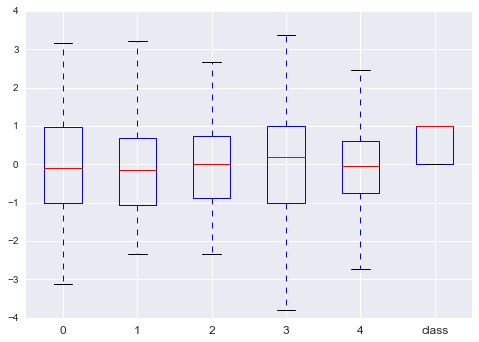

In [4]:
x = df.boxplot(return_type='dict')
plt.show()

In [5]:
df.describe()

,0,1,2,3,4,class
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,-0.026570,-0.035264,-0.008423,0.029168,-0.052110,0.501000
std,1.182997,1.166586,1.015775,1.327471,0.954592,0.500249
min,-3.107342,-2.339154,-2.346431,-3.806020,-3.116857,0.000000
25%,-1.000162,-1.058573,-0.879891,-1.006694,-0.735595,0.000000
50%,-0.100546,-0.157854,0.003162,0.185798,-0.050095,1.000000
75%,0.975560,0.686004,0.748515,0.987554,0.600995,1.000000
max,3.172533,3.646599,2.677722,3.378403,2.929096,1.000000


### Where to start?

Analyze the data and preprocess using simple statistical measurements and tools. Look for:
 - Number of features? Number of classes? (for classification)
 - Mean, Median, Mode?
 - Correlation? 
 - Dataset size? Missing samples?
 - Are samples labeled?

### Data Visualization

**Pro:** Can often be more useful than mathematical statistical analysis to get a good grasp of what the dataset looks like.
- *"Big Picture"* view

**Con:** High-dimensional data can be hard to visualize.
- Projections may be misleading.

Visualizations of the *mysterious dataset* follow...

### Pairwise Feature Plot

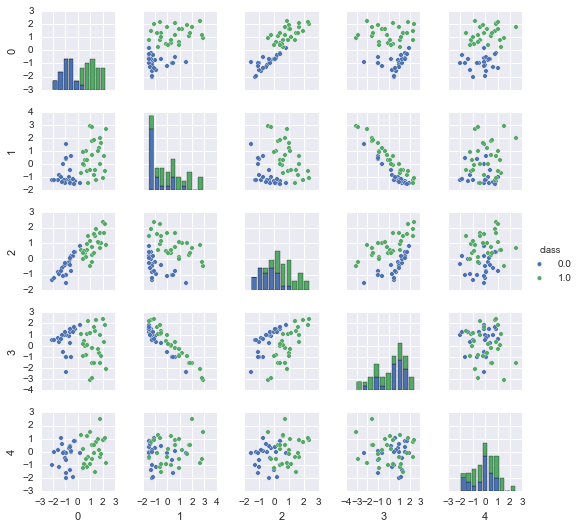

In [6]:
# Pairwise feature plot
_ = sns.pairplot(df[:50], vars=[0, 1, 2, 3, 4], hue="class", size=1.5)

### Correlation Plot

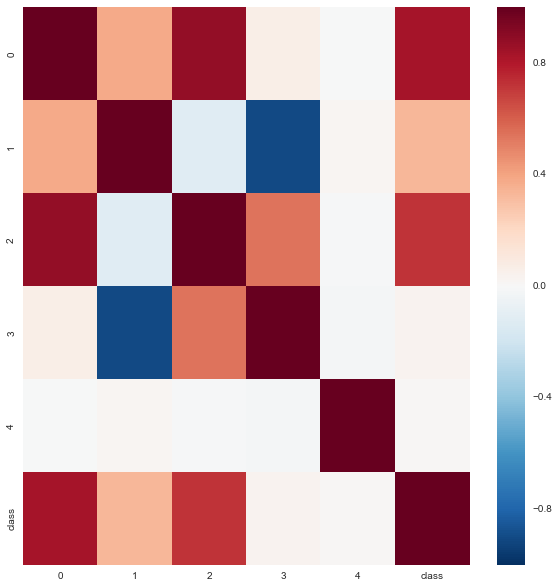

In [7]:
# Correlation Plot
plt.figure(figsize=(10, 10));
_ = sns.heatmap(df.corr(), annot=False)

### General Approaches to a Data Problem

After doing some visualization and simple statistical analysis or preprocessing of data, how should one proceed?

### Approach 1: Careful Design 
- Things to do:
 - Engineer/Select exactly the right features.
 - Collect the right dataset.
 - Design the right algorithms.
- Implement and hope it works.

### Approach 1:  Careful Design

- Pros: 
 - Can lead to new, elegant and scalable algorithms. 
 - Contributions to ML theory are generally done using this approach.
- Cons: 
 - Can be time consuming. Slow time to market for companies. 
 - "Premature optimization is the root of all evil." - Donald Knuth (Note: while this quote was intended to talk about programming, premature statistical optimization can also be quite evil.)

### Approach 2: Build and Fix
- Implement something quickly.
- Run error analyses and diagnoses to see if anything can be improved. Repeat until some performance criteria is met or goal is reached.

### Approach 2:  Build and Fix

Pros: 
- Easy especially with vast computing resources (can try different methods more easily). 
- Fast time to market.

Cons: 
- Not systematic. 
- Can miss out on the reasoning behind why a model works well. 

### Choosing a Method

Not easy to immediately decide what to use. Some things to consider first: 
- Supervised vs. Unsupervised vs. Semi-supervised vs. Active Learning vs. Reinforcement Learning ...?
- Generative vs. Discriminative? 
- Parametric vs. Non-parametric?

### Choosing a Method

Still wondering how to go about choosing methods from an applied viewpoint? 
 - There are many guides (see next few slides). 
 - Go ahead and try different algorithms! (Similar to approach 2) We will also talk about how to measure performance and deal with poor performance later.

<img src="images/sklearn_sheet.png"/>

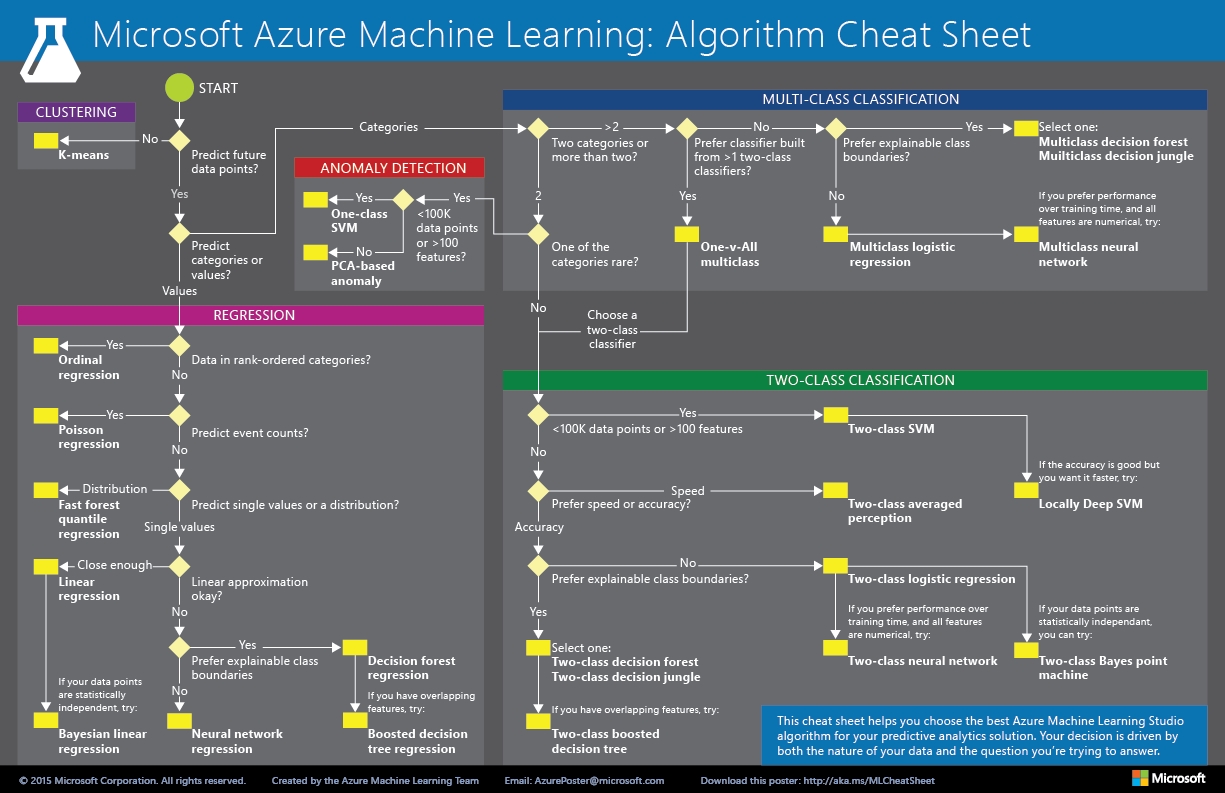

In [8]:
from IPython.display import Image
Image(filename='images/azure_sheet.png', width=800, height=600) 

## Break time!
<img src="https://img.buzzfeed.com/buzzfeed-static/static/2013-10/enhanced/webdr01/15/9/anigif_enhanced-buzz-31540-1381844535-8.gif"/>

# Statistical Inference
## Loss Functions & Bias-Variance Decomposition

### Estimators

- ML Algorithms can in general be thought of as "estimators."
> **Estimator:** A statistic (a function of data) that is used to infer the value of an unknown parameter in a statistical model.

- Suppose there is a fixed parameter $f$ that needs to be estimated. An estimator of $f$ is a function that maps the sample space to a set of sample estimates, denoted $\hat{f}$.

### Noise

- For most problems in Machine Learning, the relationship is functional but noisy.

- Mathematically, $y = f(x) + \epsilon$
    - $\epsilon$ is noise with mean $0$ variance $\sigma^2$

### Mathematical Viewpoint

- Let the training set be $D = \{\mathbf{x}_1, ..., \mathbf{x}_n\}, \mathbf{x}_i \in \mathbb{R}^d$.
- **Goal:** Find $\hat{f}$ that minimizes some **Loss function**, $L(y, \hat{f})$, which measures how good predictions are for **both** 
 - Points in $D$ (the **sample**), and, 
 - Points ***out of sample*** (outside $D$).
- Cannot minimize both perfectly because the relationship between $y$ and $\mathbf{x}$ is noisy.
 - ***Irreducible error***.

### Loss Functions

There are many loss functions, each with their own use cases and interpretations.

- **Quadratic Loss:**  $L(y,\hat{f}) = (y-\hat{f})^2$
- **Absolute Loss:**  $L(y,\hat{f}) = |y-\hat{f}|$

Classification-only loss functions:
- **Sigmoid Loss:**  $L(y,\hat{f}) = \mathrm{sigmoid}(-y\hat{f})$
- **Zero-One Loss:**  $L(y,\hat{f}) = \mathbb{I}(y \neq \hat{f})$
- **Hinge Loss:**  $L(y,\hat{f}) = \max(0, 1-y\hat{f})$
- **Logistic Loss:**  $L(y,\hat{f}) = \log[ 1 + \exp(-y\hat{f})]$
- **Exponential Loss:**  $L(y,\hat{f}) = \exp[ -y \hat{f} ]$

### Choosing a Loss Function

Different loss functions answer the following questions differently:

- How should we treat **outliers**?
- How **"correct"** do we need to be?
    - Do we want a **margin** of safety?
- What is our notion of **distance**?  What are we predicting?
    - Real-world measurements?
    - Probabilities?

### Quadratic Loss (aka Square Loss)

 - Commonly used for regression
 - Heavily influenced by outliers
 
$$
L(y, \hat{f}) = (y - \hat{f})^2
$$

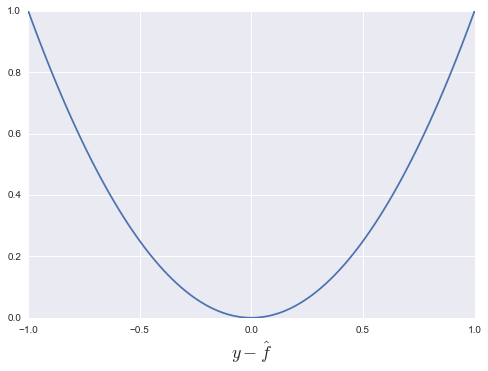

In [9]:
x = np.linspace(-1, 1, 100);
plt.plot(x, x**2)
plt.xlabel("$y-\hat{f}$", size=18);

### Absolute Loss

- Commonly used for regression.
- Robust to outliers.

$$
L(y, \hat{f}) = |y - \hat{f}|
$$

### Absolute Loss:  Plot

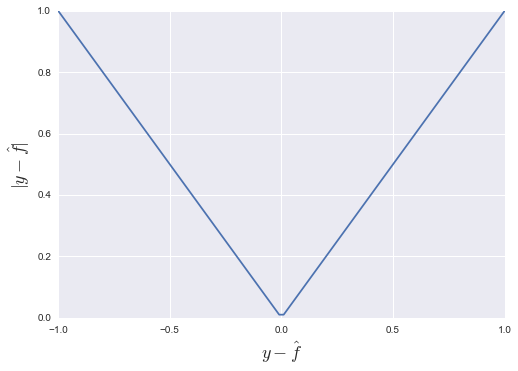

In [10]:
x = np.linspace(-1, 1, 100);
plt.plot(x, np.abs(x));
plt.xlabel("$y-\hat{f}$", size=18);
plt.ylabel("$|y-\hat{f}|$", size=18);

### 0-1 Loss

 - Used for classification. 
 - Not convex! 
  - Not practical since optimization problems become intractable!
  - "Surrogate Loss functions" that are convex and differentiable can be used instead.
  
$$
L(y, \hat{f}) = \mathbb{I}(y \neq \hat{f})
$$

### Sigmoid Loss

 - Differentiable but non-convex! Can be used for classification.
 
$$L(y,\hat{f}) = \mathrm{sigmoid}(-y\hat{f})$$

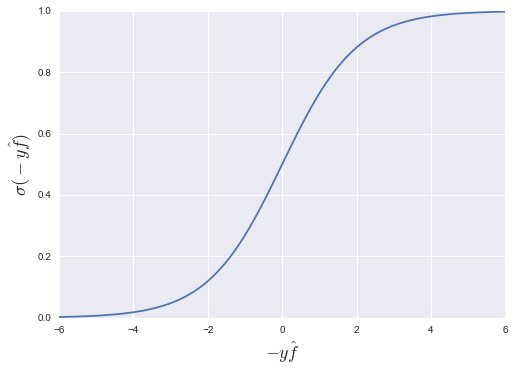

In [11]:
x = np.linspace(-6, 6, 100);
plt.plot(x, 1/(1 + np.exp(-x)));
plt.xlabel("$-y\hat{f}$", size=18);
plt.ylabel("$\sigma(-y\hat{f})$", size=18);

### Logistic Loss

 - Used in Logistic regression.
 - Influenced by outliers. 
 - Provides well calibrated probabilities (can be interpreted as confidence levels).
 
$$L(y,\hat{f}) = \log[ 1 + \exp(-y\hat{f})]$$

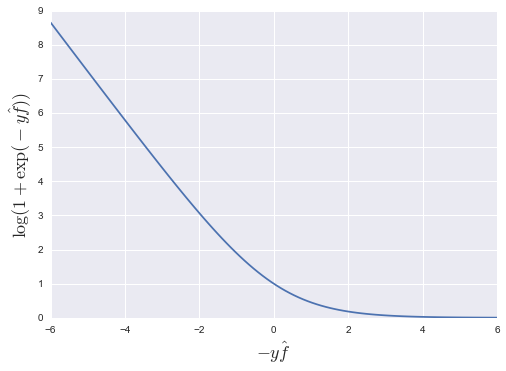

In [12]:
x = np.linspace(-6, 6, 100);
plt.plot(x, np.log2(1 + np.exp(-x)));
plt.xlabel("$-y\hat{f}$", size=18);
plt.ylabel("$\log(1 + \exp(-y\hat{f}))$", size=18);

### Hinge Loss

 - Used in SVMs. 
 - Robust to outliers.
 - Doesn't provide well calibrated probabilities.
$$L(y,\hat{f}) = \max(0, 1-y\hat{f})$$

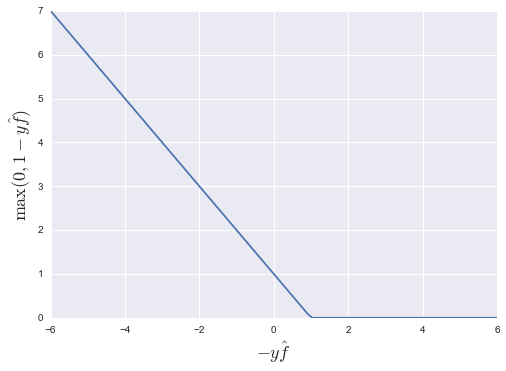

In [13]:
x = np.linspace(-6, 6, 100);
plt.plot(x, np.where(x < 1, 1 - x, 0));
plt.xlabel("$-y\hat{f}$", size=18); plt.ylabel("$\max(0,1-y\hat{f})$", size=18);

### Exponential Loss

- Used for Boosting.
- Very susceptible to outliers.
 
$$L(y,\hat{f}) = \exp(-y\hat{f})$$

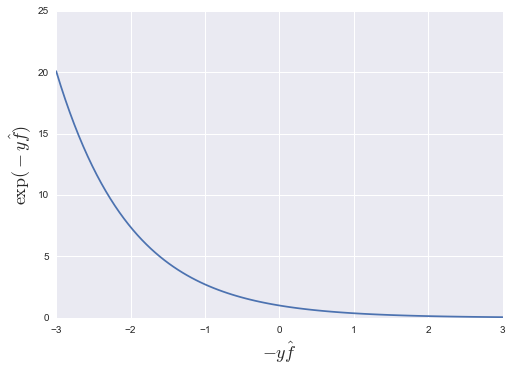

In [14]:
x = np.linspace(-3, 3, 100);
plt.plot(x, np.exp(-x));
plt.xlabel("$-y\hat{f}$", size=18);
plt.ylabel("$\exp(-y\hat{f})$", size=18);

### Loss Functions:  Comparison

In [15]:
# adapted from http://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_loss_functions.html
def plot_loss_functions():
    xmin, xmax = -4, 4
    xx = np.linspace(xmin, xmax, 100)
    plt.plot(xx, xx ** 2, 'm-',
             label="Quadratic loss")
    plt.plot([xmin, 0, 0, xmax], [1, 1, 0, 0], 'k-',
             label="Zero-one loss")
    plt.plot(xx, 1/(1 + np.exp(xx)), 'b-',
             label="Sigmoid loss")
    plt.plot(xx, np.where(xx < 1, 1 - xx, 0), 'g-',
             label="Hinge loss")
    plt.plot(xx, np.log2(1 + np.exp(-xx)), 'r-',
             label="Log loss")
    plt.plot(xx, np.exp(-xx), 'c-',
             label="Exponential loss")
    plt.ylim((0, 8))
    plt.legend(loc="best")
    plt.xlabel(r"Decision function $f(x)$")
    plt.ylabel("$L(y, f)$")

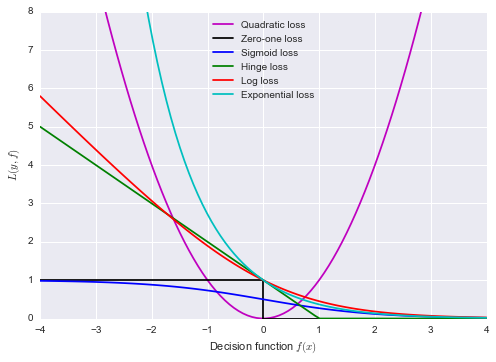

In [16]:
# Demonstrate some loss functions
plot_loss_functions()

### Risk

**Risk** is the expected loss or error.
- Calculated differently for Bayesian vs. Frequentist Statistics

For now, assume **quadratic loss** $L(y,\hat{f}) = (y-\hat{f})^2$
- Associated risk is $R(\hat{f}) = E_y[L(y, \hat{f})] = E_y[(y-\hat{f})^2]$

### Bias-Variance Decomposition

- Can decompose the expected loss into a **bias** term and **variance** term.
- Depending on samples, learning process can give different results
    - ML vs MAP vs Posterior Mean, etc..
- We want to learn a model with
    - Small bias (how well a model fits the data on average)
    - Small variance (how stable a model is w.r.t. data samples)

### Bias-Variance Decomposition

$$
\begin{align}
\mathbb{E}[(y - \hat{f})^2]
&= \mathbb{E}[y^2 - 2 \cdot y \cdot \hat{f} + {\hat{f}}^2] \\
&= \mathbb{E}[y^2] - \mathbb{E}[2 \cdot y \cdot \hat{f}] + \mathbb{E}[{\hat{f}}^2] \\
&= \mathrm{Var}[y] + {\mathbb{E}[y]}^2 - \mathbb{E}[2 \cdot y \cdot \hat{f}] + 
   \mathrm{Var}[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2
\end{align}
$$

since $Var[X] = \mathbb{E}[{X}^2] - {\mathbb{E}[X]}^2 \implies \mathbb{E}[X^2] = Var[X] + {\mathbb{E}[X]}^2$

### Bias-Variance Decomposition

$$\begin{align} \mathbb{E}[y] &= \mathbb{E}[f + \epsilon] \\
               &= \mathbb{E}[f] + \mathbb{E}[\epsilon] & \text{ (linearity of expectations)}\\
               &= \mathbb{E}[f] + 0 &\text{(zero-mean noise)}\\
               &= f & \text{ (} f \text{ is determinstic)}\end{align}$$

### Bias-Variance Decomposition

$$\begin{align} Var[y] &= \mathbb{E}[(y - \mathbb{E}[y])^2] \\
                      &= \mathbb{E}[(y - f)^2] \\
                      &= \mathbb{E}[(f + \epsilon - f)^2] \\
                      &= \mathbb{E}[\epsilon^2] \equiv \sigma^2 \end{align}$$

### Bias-Variance Decomposition

We just showed that:
- $\mathbb{E}[y] = f$  
- $\mathrm{Var}[y] = \mathbb{E}[\epsilon^2] = \sigma^2$
                
Therefore, 

$$
\begin{align}
\mathbb{E}[(y - \hat{f})^2]
&= Var[y] + {\mathbb{E}[y]}^2 - \mathbb{E}[2 \cdot y \cdot \hat{f} + Var[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2 \\
&= \sigma^2 + f^2 - \mathbb{E}[2 \cdot y \cdot \hat{f}] + Var[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2
\end{align}
$$

### Bias-Variance Decomposition

- Note $y$ is random ***only*** in $\epsilon$ (again, $f$ is deterministic). 
- Also, $\epsilon$ is ***independent*** from $\hat{f}$.

$\begin{align}\mathbb{E}[2 \cdot y \cdot \hat{f}] 
                      &= \mathbb{E}[2 \cdot y \cdot \hat{f}]\\
                      &= \mathbb{E}[2 \cdot y] \cdot \mathbb{E}[\hat{f}] & \text{ (by independence) }\\
                      &= 2 \cdot \mathbb{E}[y] \cdot \mathbb{E}[\hat{f}] \\
                      &= 2 \cdot f \cdot \mathbb{E}[\hat{f}] \end{align}$
   
Thus, we now have $\mathbb{E}[(y - \hat{f})^2] = \sigma^2 + f^2 - 2 \cdot f \cdot \mathbb{E}[\hat{f}] + Var[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2$

### Bias-Variance Decomposition

$\mathbb{E}[(y - \hat{f})^2] = \sigma^2 + Var[\hat{f}] + f^2 - 2 \cdot f \cdot \mathbb{E}[\hat{f}] + {\mathbb{E}[{\hat{f}}]}^2$

Now, $f^2 - 2 \cdot f \cdot \mathbb{E}[\hat{f}] + \mathbb{E}[\hat{f}]^2 = (f - \mathbb{E}[\hat{f}])^2$ 

$\implies \mathbb{E}[(y - \hat{f})^2] = \sigma^2 + Var[\hat{f}] + (f - \mathbb{E}[\hat{f}])^2$

$\begin{align} \text{Finally, } \mathbb{E}[f - \hat{f}] 
                        &= \mathbb{E}[f] - \mathbb{E}[\hat{f}] \text{ (linearity of expectations)} \\
                        &= f - \mathbb{E}[\hat{f}] \end{align}$
                     
So,
$$\mathbb{E}[(y - \hat{f})^2] = \underbrace{{\sigma^2}}_\text{irreducible error} + \underbrace{{\text{Var}[\hat{f}]}}_\text{Variance} + \underbrace{{\mathbb{E}[f - \mathbb{E}[\hat{f}]]}^2}_{\text{Bias}^2}$$

### Bias-Variance Decomposition

We have
$$\mathbb{E}[(y - \hat{f})^2] = \underbrace{{\sigma^2}}_\text{irreducible error} + \underbrace{{\text{Var}[\hat{f}]}}_\text{Variance} + \underbrace{{\mathbb{E}[f - \mathbb{E}_S[\hat{f}]]}^2}_{\text{Bias}^2}$$

### Bias and Variance Formulae

Bias of an estimator, $B(\hat{\theta}) = \mathbb{E}[\hat{\theta}] - \theta$

Variance of an estimator, $Var(\hat{\theta}) = \mathbb{E}[(\hat{\theta} - \mathbb{E}[\hat{\theta}])^2]$

### An example to explain Bias/Variance and illustrate the tradeoff 

- Consider estimating a sinusoidal function. 

(Example that follows is inspired by Yaser Abu-Mostafa's CS 156 Lecture titled "Bias-Variance Tradeoff"

In [17]:
import pylab as pl

RANGEXS = np.linspace(0., 2., 300)
TRUEYS = np.sin(np.pi * RANGEXS)

def plot_fit(x, y, p, show,color='k'):
    xfit = RANGEXS
    yfit = np.polyval(p, xfit)
    if show:
        axes = pl.gca()
        axes.set_xlim([min(RANGEXS),max(RANGEXS)])
        axes.set_ylim([-2.5,2.5])
        pl.scatter(x, y, facecolors='none', edgecolors=color)
        pl.plot(xfit, yfit,color=color)
        pl.hold('on')
        pl.xlabel('x')
        pl.ylabel('y')

In [18]:
def calc_errors(p):
    x = RANGEXS
    errs = []
    for i in x:
        errs.append(abs(np.polyval(p, i) - np.sin(np.pi * i)) ** 2)
    return errs

In [19]:
def calculate_bias_variance(poly_coeffs, input_values_x, true_values_y):
    # poly_coeffs: a list of polynomial coefficient vectors
    # input_values_x: the range of xvals we will see
    # true_values_y: the true labels/targes for y

    # First we calculate the mean polynomial, and compute the predictions for this mean poly
    mean_coeffs = np.mean(poly_coeffs, axis=0)
    mean_predicted_poly = np.poly1d(mean_coeffs)
    mean_predictions_y = np.polyval(mean_predicted_poly, input_values_x)
    
    # Then we calculate the error of this mean poly
    bias_errors_across_x = (mean_predictions_y - true_values_y) ** 2
    
    # To consider the variance errors, we need to look at every output of the coefficients
    variance_errors = []
    for coeff in poly_coeffs:
        predicted_poly = np.poly1d(coeff)
        predictions_y = np.polyval(predicted_poly, input_values_x)
        # Variance error is the average squared error between the predicted values of y
        # and the *average* predicted value of y
        variance_error = (mean_predictions_y - predictions_y)**2
        variance_errors.append(variance_error)

    variance_errors_across_x = np.mean(np.array(variance_errors),axis=0)
    
    return bias_errors_across_x, variance_errors_across_x

In [20]:
from matplotlib.pylab import cm
def polyfit_sin(degree=0, iterations=100, num_points=5, show=True):
    total = 0
    l = []
    coeffs = []
    errs = [0] * len(RANGEXS)
    colors=cm.rainbow(np.linspace(0,1,iterations))
    for i in range(iterations):
        np.random.seed()
        x = np.random.choice(RANGEXS,size=num_points) # Pick random points from the sinusoid
        y = np.sin(np.pi * x)
        p = np.polyfit(x, y, degree)  
        y_poly = [np.polyval(p, x_i) for x_i in x]  
        plot_fit(x, y, p, show,color=colors[i])
        total += sum(abs(y_poly - y) ** 2) # calculate Squared Error (Squared Error) 
        coeffs.append(p)
        errs = np.add(calc_errors(p), errs)
    return total / iterations, errs / iterations, np.mean(coeffs, axis = 0), coeffs

In [21]:
def plot_bias_and_variance(biases,variances,range_xs,true_ys,mean_predicted_ys):
    pl.plot(range_xs, mean_predicted_ys, c='k')
    axes = pl.gca()
    axes.set_xlim([min(range_xs),max(range_xs)])
    axes.set_ylim([-3,3])
    pl.hold('on')
    pl.plot(range_xs, true_ys,c='b')
    pl.errorbar(range_xs, mean_predicted_ys, yerr = biases, c='y', ls="None", zorder=0,alpha=1)
    pl.errorbar(range_xs, mean_predicted_ys, yerr = variances, c='r', ls="None", zorder=0,alpha=0.1)
    pl.xlabel('x')
    pl.ylabel('y')

## Let's return to fitting polynomials

* Here we generate some samples $x,y$, with $y = \sin(2\pi x)$
* We then fit a *degree-0$ polynomial (i.e. a constant function) to the samples 

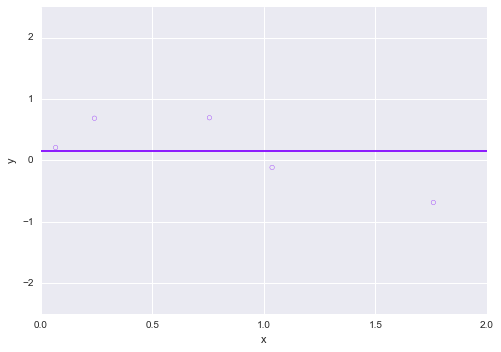

In [22]:
# polyfit_sin() generates 5 samples of the form (x,y) where y=sin(2*pi*x)
# then it tries to fit a degree=0 polynomial (i.e. a constant func.) to the data
# Ignore return values for now, we will return to these later
_, _, _, _ = polyfit_sin(degree=0, iterations=1, num_points=5, show=True)

## We can do this over many datasets

* Let's sample a number of datasets
* How does the fitted polynomial change for different datasets?

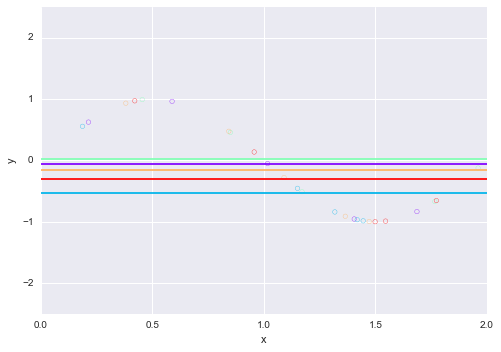

In [23]:
# Estimate two points of sin(pi * x) with a constant 5 times
_, _, _, _ = polyfit_sin(0, 5)

## What about over lots more datasets?


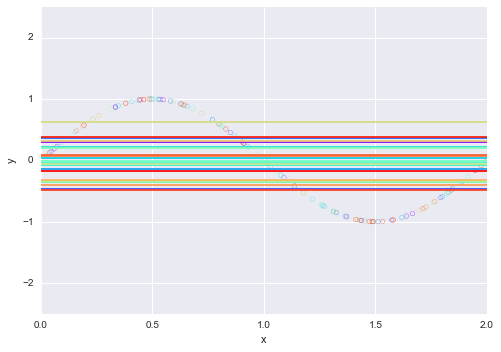

In [24]:
# Estimate two points of sin(pi * x) with a constant 100 times
_, _, _, _ = polyfit_sin(0, 25)

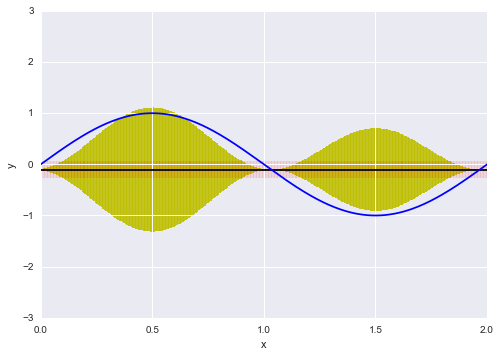

In [25]:
MSE, errs, mean_coeffs, coeffs_list = polyfit_sin(0, 100,num_points = 3,show=False)
biases, variances = calculate_bias_variance(coeffs_list,RANGEXS,TRUEYS)
plot_bias_and_variance(biases,variances,RANGEXS,TRUEYS,np.polyval(np.poly1d(mean_coeffs), RANGEXS))

* Decomposition: $\mathbb{E}[(y - \hat{f})^2] = \underbrace{{\sigma^2}}_\text{irreducible error} + \underbrace{{\text{Var}[\hat{f}]}}_\text{Variance} + \underbrace{{\mathbb{E}[f - \mathbb{E}_S[\hat{f}]]}^2}_{\text{Bias}^2}$
* Blue curve: true $f$
* Black curve: $\hat f$, average predicted values of $y$
* Yellow is error due to **Bias**, Red/Pink is error due to **Variance**

## Bias vs. Variance
* We can calculate how much error we suffered due to bias and due to variance

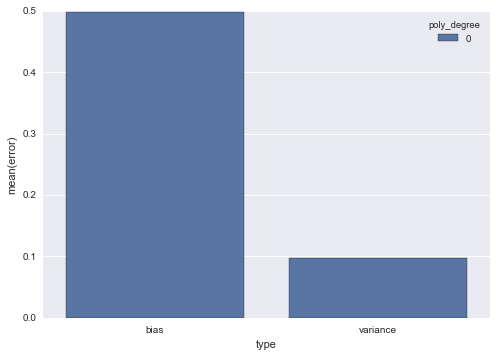

In [26]:
poly_degree = 0
results_list = []
MSE, errs, mean_coeffs, coeffs_list = polyfit_sin(
    poly_degree, 500,num_points = 5,show=False)
biases, variances = calculate_bias_variance(coeffs_list,RANGEXS,TRUEYS)
sns.barplot(x='type', y='error',hue='poly_degree', data=pd.DataFrame([
    {'error':np.mean(biases), 'type':'bias','poly_degree':0},
    {'error':np.mean(variances), 'type':'variance','poly_degree':0}]))

## Let's now fit degree=3 polynomials

* Let's sample a dataset of 5 points and fit a cubic poly

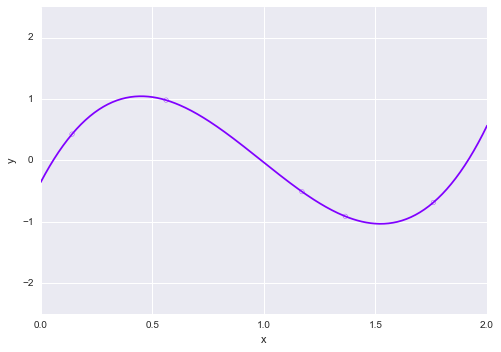

In [27]:
MSE, _, _, _ = polyfit_sin(degree=3, iterations=1)

## Let's now fit degree=3 polynomials

* What does this look like over 5 different datasets?

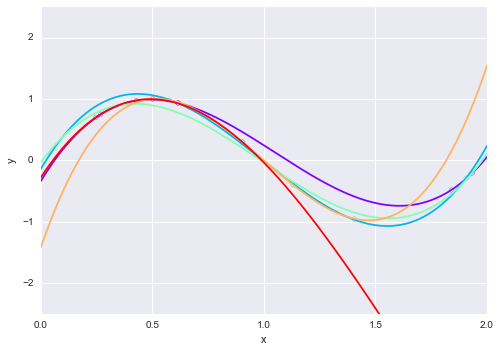

In [28]:
_, _, _, _ = polyfit_sin(degree=3,iterations=5,num_points=5,show=True)

## Let's now fit degree=3 polynomials

* What does this look like over 50 different datasets?

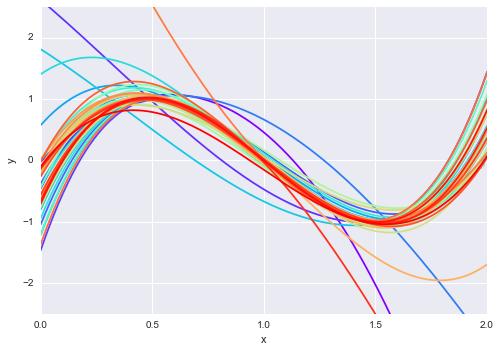

In [29]:
# Estimate two points of sin(pi * x) with a line 50 times
_, _, _, _ = polyfit_sin(degree=3, iterations=50)

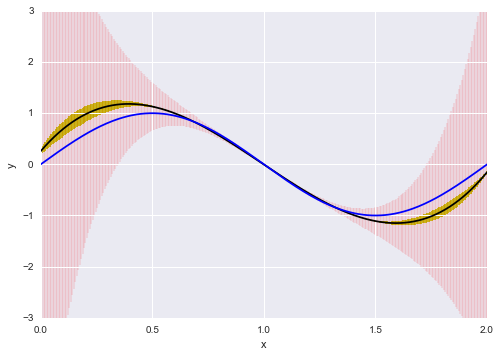

In [30]:
MSE, errs, mean_coeffs, coeffs_list = polyfit_sin(3,500,show=False)
biases, variances = calculate_bias_variance(coeffs_list,RANGEXS,TRUEYS)
plot_bias_and_variance(biases,variances,RANGEXS,TRUEYS,np.polyval(np.poly1d(mean_coeffs), RANGEXS))

$$\mathbb{E}[(y - \hat{f})^2] = \underbrace{{\sigma^2}}_\text{irreducible error} + \underbrace{{\text{Var}[\hat{f}]}}_\text{Variance} + \underbrace{{\mathbb{E}[f - \mathbb{E}_S[\hat{f}]]}^2}_{\text{Bias}^2}$$
* Blue curve: true $f$
* Black curve: $\hat f$, average predicted values of $y$
* Yellow is error due to **Bias**, Red/Pink is error due to **Variance**

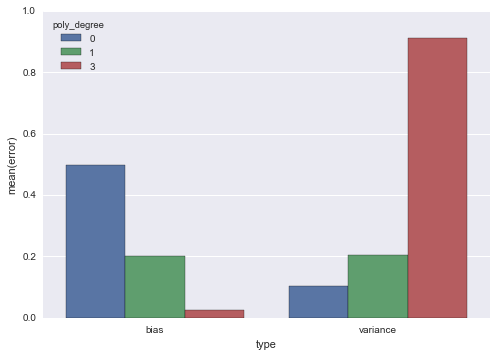

In [31]:
results_list = []
for poly_degree in [0,1,3]:
    MSE, errs, mean_coeffs, coeffs_list = polyfit_sin(poly_degree,500,num_points=5,show=False)
    biases, variances = calculate_bias_variance(coeffs_list,RANGEXS,TRUEYS)
    results_list.append({'error':np.mean(biases),
                         'type':'bias', 'poly_degree':poly_degree})
    results_list.append({'error':np.mean(variances),
                         'type':'variance', 'poly_degree':poly_degree})

sns.barplot(x='type', y='error',hue='poly_degree',data=pd.DataFrame(results_list))

### Bias Variance Tradeoff

#### Central problem in supervised learning. 

Ideally, one wants to choose a model that both accurately captures the regularities in its training data, but also generalizes well to unseen data. Unfortunately, it is typically impossible to do both simultaneously. 

- High Variance: 
 - Model represents the training set well. 
 - Overfit to noise or unrepresentative training data. 
 - Poor generalization performance


- High Bias: 
 - Simplistic models.
 - Fail to capture regularities in the data.
 - May give better generalization performance.

### Interpretations of Bias
 - Captures the errors caused by the simplifying assumptions of a model.
 - Captures the average errors of a model across different training sets.

### Interpretations of Variance
 - Captures how much a learning method moves around the mean. 
 - How different can one expect the hypotheses of a given model to be?
 - How sensitive is an estimator to different training sets?

### Complexity of Model

- Simple models generally have high bias and complex models generally have low bias. 
- Simple models generally have low variance andcomplex models generally have high variance.


- Underfitting / Overfitting
 - High variance is associated with overfitting.
 - High bias is associated with underfitting.

### Training set size
 
- Decreasing the training set size
 - Helps with a high bias algorithm: 
  - Will in general not help in improving performance. 
  - Can attain the same performance with smaller training samples however.
  - Additional advantage of increases in speed.


- Increase the training set size
 - Decreases Variance by reducing overfitting.

### Number of features
- Increasing the number of features.
 - Decreases bias at the expense of increasing the variance.

- Decreasing the number of features.
 - Dimensionality reduction can decrease variance by reducing over-fitting.


### Features 

Many techniques for engineering and selecting features (Feature Engineering and Feature Extraction)
 - PCA, Isomap, Kernel PCA, Autoencoders, Latent sematic analysis, Nonlinear dimensionality reduction, Multidimensional Scaling

### Features

The importance of features
 > "Coming up with features is difficult, time-consuming, requires expert knowledge.  Applied machine learning is basically feature engineering" 
 - Andrew Ng
 
 
 > "... some machine learning projects succeed and some fail.  What makes the difference? Easily the most important factor is the features used." 
 - Pedro Domingo

### Regularization (Changing $\lambda$)

Regularization is designed to impose simplicity by adding a penalty term that depends on the charactistics of the parameters.

- Decrease Regularization. 
 - Reduces bias (allows the model to be more complex).
 
 
- Increase Regularization.
 - Reduces variance by reducing overfitting (again, regularization imposes "simplicity.") 

### Ideal bias and variance?

- All is not lost. Bias and Variance can both be lowered through some methods:
 - Ex: Boosting (learning from weak classifiers).

- The sweet spot for a model is the level of complexity at which the increase in bias is equivalent to the reduction in variance. 

# Model Selection

### Model Selection 

- ML Algorithms generally have a lot of parameters that must be chosen. A natural question is then "How do we choose them?"
 - Examples: Penalty for margin violation (C), Polynomial Degree in polynomial fitting

### Model Selection

- Simple Idea: 
 - Construct models $M_i, i = 1, ..., n$.
 - Train each of the models to get a hypothesis $h_i, i = 1, ..., n$.
 - Choose the best.
- Does this work? No! Overfitting. This brings us to **cross validation**.

### Hold-Out Cross Validation 

(1) Randomly split the training data $D$ into $D_{train}$ and $D_{val}$, say 70% of the data and 30% of the data respectively.

(2) Train each model $M_i$ on $D_{train}$ only, each time getting a hypothesis $h_i$.

(3) Select and output hypothesis $h_i$ that had the smallest error on the held out validation set.

Disadvantages: 
 - Waste some sizable amount of data (30\% in the above scenario) so that less training examples are available.
 - Using only some data for training and other data for validation.

### K-Fold Cross Validation (Step 1)

Randomly split the training data $D$ into $K$ ***disjoint*** subsets of $N/K$ training samples each.
 - Let these subsets be denoted $D_1, ..., D_K$.

### K-Fold Cross Validation (Step 2)

For each model $M_i$, we evaluate the model as follows: 
 - Train the model $M_i$ on $D \setminus D_k$ (all of the subsets except subset $D_k$) to get hypothesis $h_i(k)$.
 - Test the hypothesis $h_i(k)$ on $D_k$ to get the error (or loss) $\epsilon_i(k)$.
 - Estimated generalization error for model $M_i$ is then given by $e^g_i = \frac{1}{K} \sum \limits_{k = 1}^K \epsilon_i (k)$

### K-Fold Cross Validation (Step 3)

Pick the model $M_i^*$ with the lowest estimated generalization error $e^{g*}_i$ and retrain the model on the entire training set, thus giving the final hypothesis $h^*$ that is output.

### Three Way Data Splits

- If model selection and true error estimates are to be computed simaltaneously, the data needs to be divided into three disjoin sets.

- Training set: A set of examples used for learning
- Validation set: A set of examples used to tune the hyperparameters of a classifier.
- Test Set: A set of examples used *** only *** to assess the performance of a fully-trained model.

### Procedure Outline

1. Divide the available data into training, validation and test set
2. Select a model (and hyperparameters)
3. Train the model using the training set
4. Evaluate the model using the validation set
5. Repeat steps 2 through 4 using different models (and hyperparameters)
6. Select the best model (and hyperparameter) and train it using data from the training and validation set
7. Assess this final model using the test set

### How to choose hyperparameters?

Cross Validation is only useful if we have some number of models. This often means constructing models each with a different combination of hyperparameters.

### Random Search
 - Just choose each hyperparameter randomly (possibly within some range for each.)
 - Pro: Easy to implement. Viable for models with a small number of hyperparameters and/or low dimensional data.
 - Con: Very inefficient for models with a large number of hyperparameters or high dimensional data (curse of dimensionality.)

### Grid Search / Parameter Sweep
 - Choose a subset for each of the parameters.
  - Discretize real valued parameters with step sizes as necessary.
 - Output the model with the best cross validation performance. 
 - Pro: "Embarassingly Parallel" (Can be easily parallelized)
 - Con: Again, curse of dimensionality poses problems.

### Bayesian Optimization
 
- Assumes that there is a smooth but noisy relation that acts as a mapping from hyperparameters to the objective function.

- Gather observations in such a manner as to evaluate the machine learning model the least number of times while revealing as much information as possible about the mapping and, in particular, the location of the optimum.

- Exploration vs. Exploitation problem.

### Learning Curves
Provide a visualization for diagnostics such as:
- Bias / variance
- Convergence 

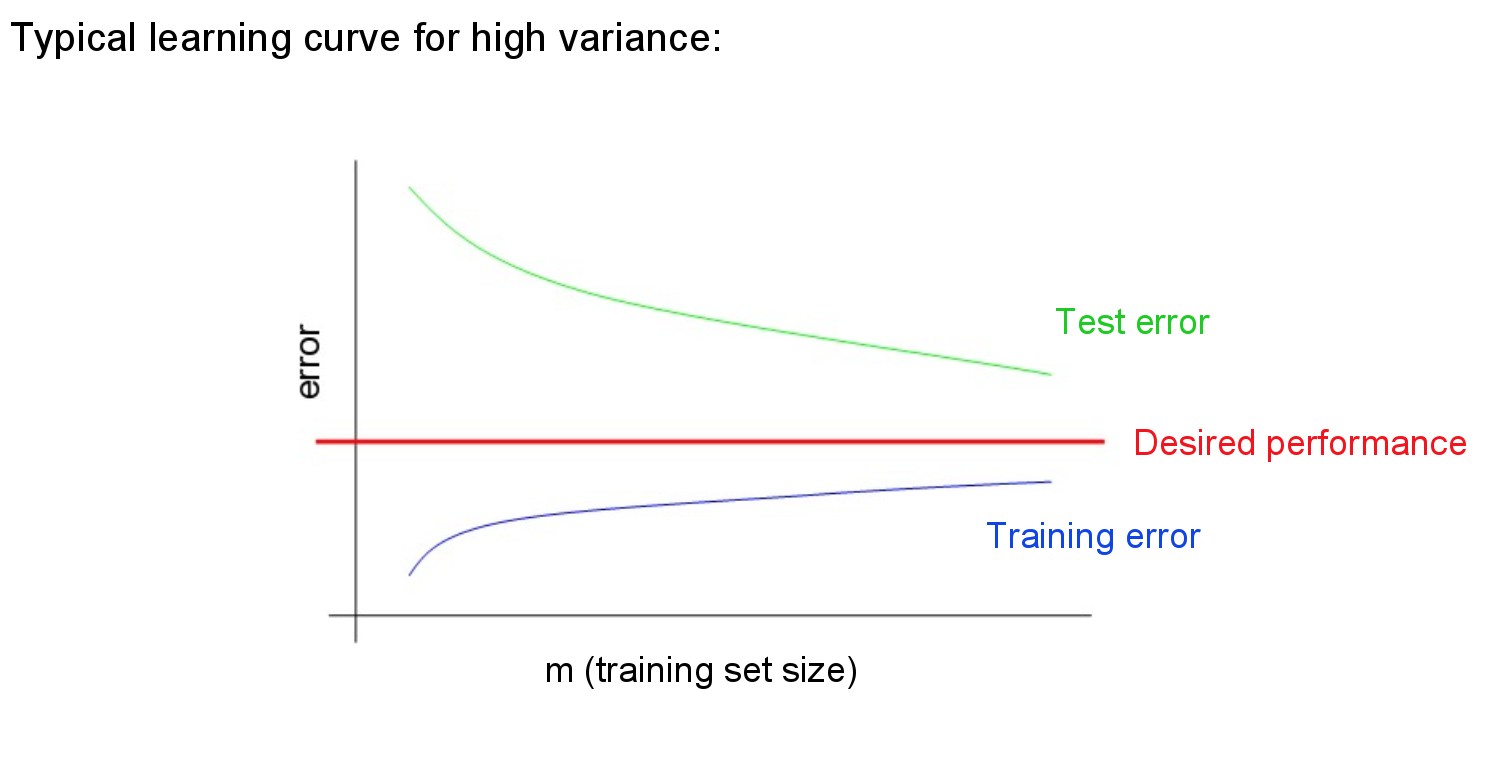

In [32]:
# Image from Andrew Ng's Stanford CS229 lecture titled "Advice for applying machine learning"
from IPython.display import Image
Image(filename='images/HighVariance.png', width=800, height=600)

# Testing error still decreasing as the training set size increases. Suggests increasing the training set size.
# Large gap Between Training and Test Error.

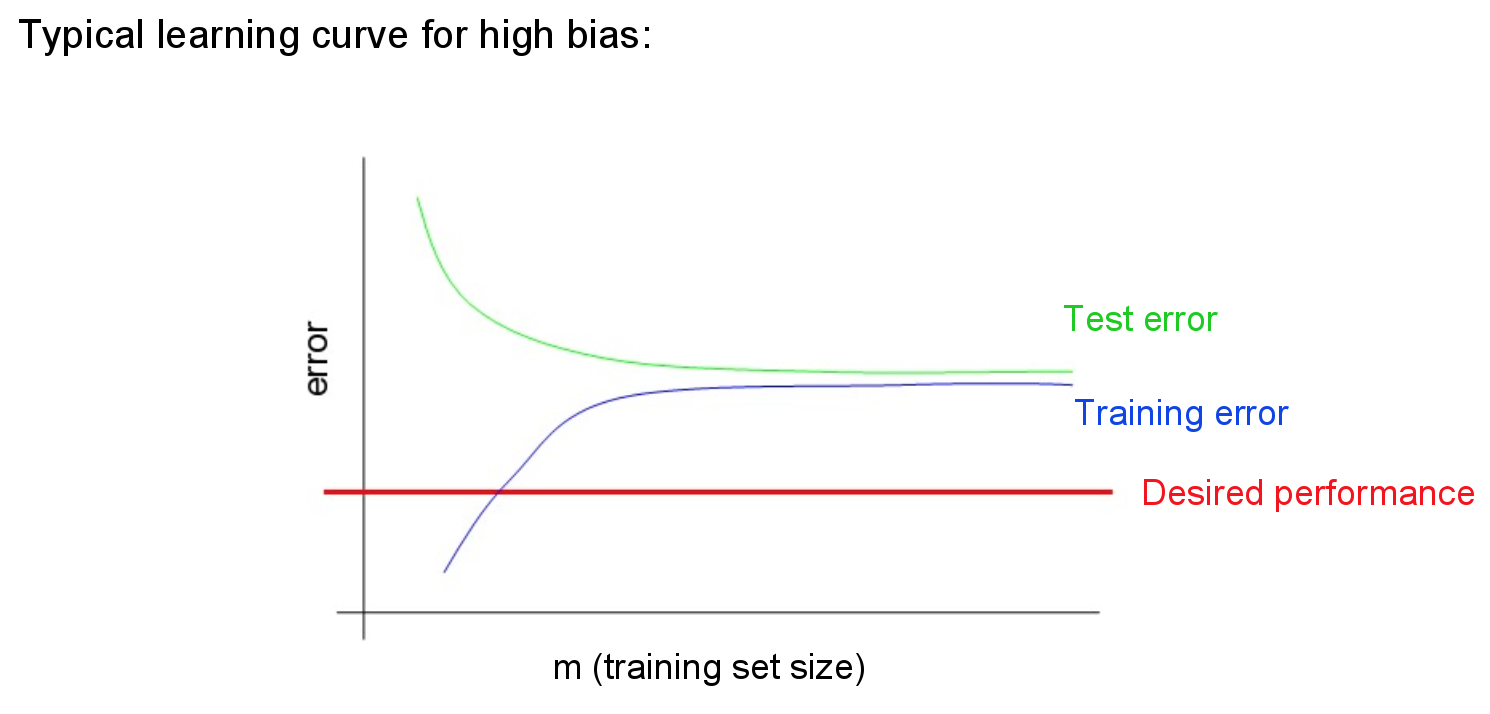

In [33]:
# Image from Andrew Ng's Stanford CS229 lecture titled "Advice for applying machine learning"
from IPython.display import Image
Image(filename='images/HighBias.png', width=800, height=600)

# Training error is unacceptably high.
# Small gap between training error and testing error.

### Convergence

- Approach 1: 
 - Measure gradient of the learning curve.
 - As learning curve gradient approaches 0, the model has been trained. Choose threshold to stop training.

- Approach 2: 
 - Measure change in the model parameters each iteration of the algorithm.
 - One can assume that training is complete when the change in model parameters is below some threshold.

### Diagnostics related to Convergence (1)
- Convergence too slow? 
 - Try using Newton's method.
 - Larger step size. 
  - Note that too large of a step size could also lead to slow convergence (but the learning curves in general will then suggest instability if "oscillations" are occuring.)
 - Decrease batch size if using a batch based optimization algorithm.

### Diagnostics related to Convergence (2)

- Are the learning curves stable? If not: 
 - Switch to a batch style optimization algorithm if not already using one (like minibatch gradient descent / gradient descent).
 - Increase batch sizes if already using one.
- Some algorithms always ensure a decrease or increase in the objective function each iterations. Ensure that this is the case if the optimization algorithm being used provides such guarantees.

### Ablative Analysis

- Similar to the idea of cross validation, except for components of a system.

- Example: Simple Logisitic Regression on spam classification gives 94% performance.
 - 95% with spell correction
 - 96% with top 100 most commonly used words removed
 - 98% with extra sender and receiver information 
 - 99% overall performance